In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import seaborn
import plotly.express as px
plt.style.use('seaborn')

import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

In [2]:
#creates connection to mongodb
client = pymongo.MongoClient()
db = client.tweeter

In [88]:
bernie_coll = db.bernie_tweets
joe_coll = db.joe_tweets
pete_coll = db.pete_tweets
warren_coll = db.warren_tweets
amy_coll = db.amy_tweets

In [89]:
#retrieved data from mongo into a dataframe
bernie_df = pd.DataFrame(list(bernie_coll.find()))
joe_df = pd.DataFrame(list(joe_coll.find()))
pete_df = pd.DataFrame(list(pete_coll.find()))
warren_df = pd.DataFrame(list(warren_coll.find()))
amy_df = pd.DataFrame(list(amy_coll.find()))

In [6]:
bernie_df.set_index('date')

,_id,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
date,,,,,,,,,,,,
2020-02-23 23:08:28,5e544761137a410232c1773e,BernieSanders,NaN,1025,3705,23609,"We won the popular vote in Iowa, we won the Ne...",NaN,NaN,NaN,1231717490742292480,https://twitter.com/BernieSanders/status/12317...
2020-02-23 23:04:57,5e544761137a410232c1773f,BernieSanders,NaN,371,956,4533,"This campaign has the momentum to win, but we ...",NaN,NaN,NaN,1231716605622657025,https://twitter.com/BernieSanders/status/12317...
2020-02-23 22:34:47,5e544761137a410232c17740,BernieSanders,NaN,1047,5017,44742,"As president, I will support the rights of bot...",NaN,NaN,NaN,1231709011688480768,https://twitter.com/BernieSanders/status/12317...
2020-02-23 22:34:46,5e544761137a410232c17741,BernieSanders,NaN,4042,15101,97230,The Israeli people have the right to live in p...,NaN,NaN,NaN,1231709010430189570,https://twitter.com/BernieSanders/status/12317...
2020-02-23 20:20:37,5e544761137a410232c17742,BernieSanders,NaN,6105,9230,63002,Trump and his friends think they're going to w...,NaN,NaN,NaN,1231675250963832833,https://twitter.com/BernieSanders/status/12316...
...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-19 18:25:30,5e544761137a410232c1a8ce,BernieSanders,NaN,0,1,0,Bernie Sanders's Progressive Plan to Balance B...,NaN,NaN,NaN,5688127838486528,https://twitter.com/BernieSanders/status/56881...
2010-11-17 21:50:00,5e544761137a410232c1a8cf,BernieSanders,NaN,0,1,0,Have you signed Bernie's petition against the ...,NaN,NaN,NaN,5014819757363200,https://twitter.com/BernieSanders/status/50148...
2010-11-17 21:49:06,5e544761137a410232c1a8d0,BernieSanders,NaN,0,0,0,Bernie's 2012 reelection campaign is now on tw...,NaN,NaN,NaN,5014590958080000,https://twitter.com/BernieSanders/status/50145...


In [29]:
b_df = bernie_df[~bernie_df['text'].isnull()]

In [11]:
sentiment_objects = [TextBlob(tweet) for tweet in b_df['text']]

In [12]:
# Create list of polarity valuesx and tweet text
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

In [13]:
# Create dataframe containing the polarity value and tweet text
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

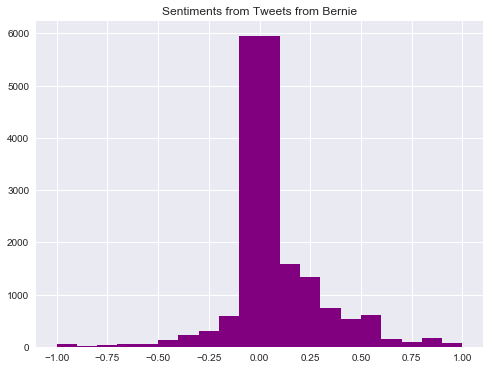

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                        0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets from Bernie")
plt.show()

In [17]:
sentiment_df.sort_values(by='polarity')

,polarity,tweet
862,-1.0,The outrageous abuse taking place at Glenwood ...
6719,-1.0,I condemn the horrific terrorist attack in Jer...
9125,-1.0,What an outrageous and bigoted statement. @rea...
2001,-1.0,Our health care system is cruel and barbaric. ...
4668,-1.0,"My thoughts are with the people of Barcelona, ..."
...,...,...
8492,1.0,Congrats to Kappa Alpha Psi Inc. on 105 years ...
3445,1.0,We set a goal of 1 million donations not becau...
6925,1.0,We need your help today to win Wisconsin! Make...
12644,1.0,#Filibernie's Greatest Hits http://motherjones...


In [24]:
b_df[b_df['favorites'] > 0]

,_id,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,5e544761137a410232c1773e,2020-02-23 23:08:28,BernieSanders,NaN,1025,3705,23609,"We won the popular vote in Iowa, we won the Ne...",NaN,NaN,NaN,1231717490742292480,https://twitter.com/BernieSanders/status/12317...
1,5e544761137a410232c1773f,2020-02-23 23:04:57,BernieSanders,NaN,371,956,4533,"This campaign has the momentum to win, but we ...",NaN,NaN,NaN,1231716605622657025,https://twitter.com/BernieSanders/status/12317...
2,5e544761137a410232c17740,2020-02-23 22:34:47,BernieSanders,NaN,1047,5017,44742,"As president, I will support the rights of bot...",NaN,NaN,NaN,1231709011688480768,https://twitter.com/BernieSanders/status/12317...
3,5e544761137a410232c17741,2020-02-23 22:34:46,BernieSanders,NaN,4042,15101,97230,The Israeli people have the right to live in p...,NaN,NaN,NaN,1231709010430189570,https://twitter.com/BernieSanders/status/12317...
4,5e544761137a410232c17742,2020-02-23 20:20:37,BernieSanders,NaN,6105,9230,63002,Trump and his friends think they're going to w...,NaN,NaN,NaN,1231675250963832833,https://twitter.com/BernieSanders/status/12316...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12678,5e544761137a410232c1a8c4,2010-12-01 19:34:37,BernieSanders,NaN,0,0,1,WSJ.com - A Glimpse at the Socialist Senator W...,NaN,NaN,NaN,10054180030914560,https://twitter.com/BernieSanders/status/10054...
12683,5e544761137a410232c1a8c9,2010-11-30 15:54:03,BernieSanders,NaN,0,1,1,Sanders: Dems must stand firm on tax cuts for ...,NaN,NaN,NaN,9636280816111616,https://twitter.com/BernieSanders/status/96362...
12684,5e544761137a410232c1a8ca,2010-11-24 15:00:41,BernieSanders,NaN,0,0,1,Sen. Franken wants DOJ to probe Comcast on ant...,NaN,NaN,NaN,7448524853612544,https://twitter.com/BernieSanders/status/74485...
12685,5e544761137a410232c1a8cb,2010-11-22 16:44:42,BernieSanders,NaN,0,4,19,Bernie Sanders on the Class War and President ...,NaN,NaN,NaN,6749926641897472,https://twitter.com/BernieSanders/status/67499...


In [52]:
bern_df = b_df.set_index('date')

In [58]:
bern_df.index = pd.to_datetime(bern_df.index)

In [77]:
bern_df.head()

,_id,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink,year,month,wk_name
date,,,,,,,,,,,,,,,
2020-02-23 23:08:28,5e544761137a410232c1773e,BernieSanders,NaN,1025,3705,23609,"We won the popular vote in Iowa, we won the Ne...",NaN,NaN,NaN,1231717490742292480,https://twitter.com/BernieSanders/status/12317...,2020,2,Sunday
2020-02-23 23:04:57,5e544761137a410232c1773f,BernieSanders,NaN,371,956,4533,"This campaign has the momentum to win, but we ...",NaN,NaN,NaN,1231716605622657025,https://twitter.com/BernieSanders/status/12317...,2020,2,Sunday
2020-02-23 22:34:47,5e544761137a410232c17740,BernieSanders,NaN,1047,5017,44742,"As president, I will support the rights of bot...",NaN,NaN,NaN,1231709011688480768,https://twitter.com/BernieSanders/status/12317...,2020,2,Sunday
2020-02-23 22:34:46,5e544761137a410232c17741,BernieSanders,NaN,4042,15101,97230,The Israeli people have the right to live in p...,NaN,NaN,NaN,1231709010430189570,https://twitter.com/BernieSanders/status/12317...,2020,2,Sunday
2020-02-23 20:20:37,5e544761137a410232c17742,BernieSanders,NaN,6105,9230,63002,Trump and his friends think they're going to w...,NaN,NaN,NaN,1231675250963832833,https://twitter.com/BernieSanders/status/12316...,2020,2,Sunday


In [61]:
bern_df['year'] = bern_df.index.year
bern_df['month'] = bern_df.index.month
bern_df['wk_name'] = bern_df.index.weekday_name

In [ ]:
[TextBlob(tweet) for tweet in bern_df['text']]

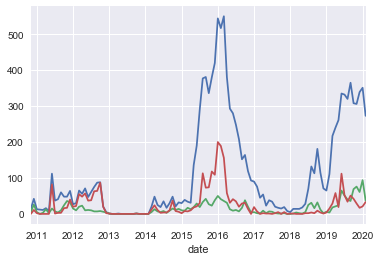

In [78]:
bern_df.resample('M')['text'].count().plot()
bern_df.resample('M')['mentions'].count().plot()
bern_df.resample('M')['hashtags'].count().plot()
plt.show()

In [70]:
def polyplot(df):
    n_df = df[~df['text'].isnull()]
    show_df = n_df.set_index('date')
    show_df.index = pd.to_datetime(show_df.index)

    show_df.resample('M')['text'].count().plot()
    show_df.resample('M')['mentions'].count().plot()
    return plt.show()

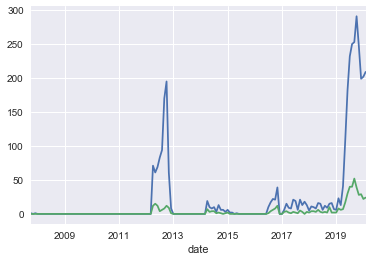

In [71]:
polyplot(joe_df)

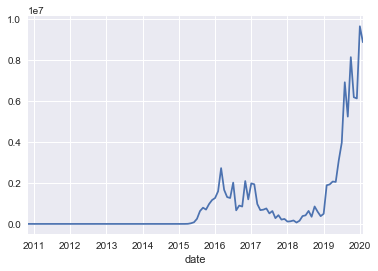

In [74]:
bern_df.resample('M')['favorites'].sum().plot()
plt.show()

In [75]:
bern_df.resample('M')['favorites'].sum()

date
2010-11-30        120
2010-12-31        105
2011-01-31          8
2011-02-28         15
2011-03-31          3
               ...   
2019-10-31    8135165
2019-11-30    6179098
2019-12-31    6118637
2020-01-31    9640608
2020-02-29    8863625
Freq: M, Name: favorites, Length: 112, dtype: int64

In [184]:
def polyplot(df, rate='M'):
    n_df = df[~df['text'].isnull()]
    show_df = n_df.set_index('date')
    show_df.index = pd.to_datetime(show_df.index)
    return show_df.resample(rate)['text'].count()

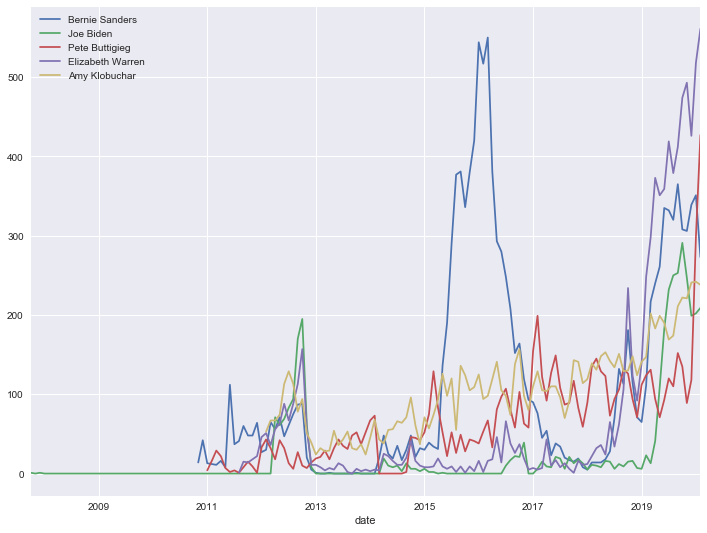

In [185]:
fig, ax = plt.subplots(figsize=(12,9))
polyplot(bernie_df).plot()
polyplot(joe_df).plot()
polyplot(pete_df).plot()
polyplot(warren_df).plot()
polyplot(amy_df).plot()
labels = ['Bernie Sanders', 'Joe Biden', 'Pete Buttigieg', 'Elizabeth Warren ', 'Amy Klobuchar']
plt.legend(labels)
plt.show()

In [189]:
data = pd.concat([polyplot(bernie_df, rate='D'),polyplot(joe_df, rate='D'), 
                  polyplot(pete_df, rate='D'), polyplot(warren_df, rate='D'),
                  polyplot(amy_df, rate='D')], axis=1)

In [190]:
cols=['bernie', 'joe', 'pete', 'warren', 'amy']

In [191]:
data.columns = cols

In [192]:
def plot_trend(x, y):
    title = "{} Text Trends".format(y.capitalize())
    fig=px.line(data, x=x, y=y, title=title)
    return fig.show()

In [193]:
plot_trend(data.index, 'warren')
plot_trend(data.index, 'joe')